In [ ]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from google.colab import files
from google.colab.patches import cv2_imshow

In [43]:
uploaded = files.upload()

Saving 1415_vik.tif to 1415_vik (5).tif


In [ ]:
image_path = list(uploaded.keys())[0]
image = cv2.imread(image_path)

In [ ]:
height, width, channels = image.shape
image_2d = image.reshape((height * width, channels))

In [ ]:
num_clusters = 5  # You can adjust this based on the characteristics of your data
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(image_2d)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=5, random_state=42)

In [ ]:
labels = kmeans.labels_
hotspot_label = np.argmax(np.bincount(labels))

In [ ]:
hotspot_mask = (labels == hotspot_label).reshape((height, width))
hotspot_highlight = image.copy()
hotspot_highlight[hotspot_mask == 0] = [0, 0, 0]

In [ ]:
hotspot_centroid = kmeans.cluster_centers_[hotspot_label]

In [ ]:
distances = np.linalg.norm(image_2d - hotspot_centroid, axis=1)

In [ ]:
scaler = StandardScaler()
distances_scaled = scaler.fit_transform(distances.reshape(-1, 1))

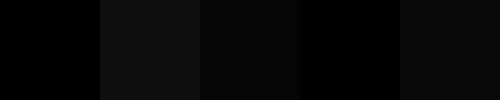

In [47]:
# Plotting cluster centroids on the image
cluster_centers = kmeans.cluster_centers_.astype(np.uint8)
cluster_centers_image = np.zeros((100, num_clusters * 100, 3), dtype=np.uint8)

for i, center in enumerate(cluster_centers):
    cluster_centers_image[:, i * 100:(i + 1) * 100] = center

cv2_imshow(cv2.cvtColor(cluster_centers_image, cv2.COLOR_BGR2RGB))

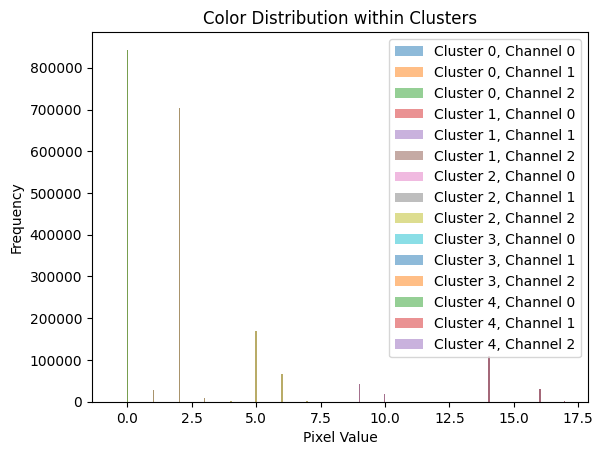

In [48]:
import matplotlib.pyplot as plt

# Create histograms for each color channel within clusters
for i in range(num_clusters):
    cluster_pixels = image_2d[labels == i]
    for channel in range(channels):
        plt.hist(cluster_pixels[:, channel], bins=50, alpha=0.5, label=f'Cluster {i}, Channel {channel}')

plt.legend()
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.title('Color Distribution within Clusters')
plt.show()

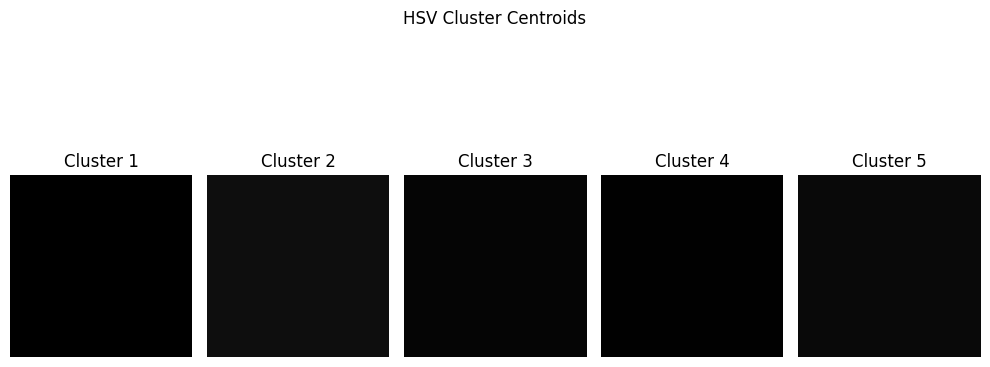

In [54]:
# Retrieve cluster centroids in HSV space
cluster_centers_hsv = kmeans_hsv.cluster_centers_.astype(np.uint8)

# Create an image to display the cluster centroids
cluster_centers_image_hsv = np.zeros((100, num_clusters * 100, 3), dtype=np.uint8)

for i, center in enumerate(cluster_centers_hsv):
    cluster_centers_image_hsv[:, i * 100:(i + 1) * 100] = center

from matplotlib import pyplot as plt

# Display the cluster centroids in HSV space using matplotlib
plt.figure(figsize=(10, 5))
for i, center in enumerate(cluster_centers_hsv):
    color_patch = np.zeros((100, 100, 3), dtype=np.uint8)
    color_patch[:, :] = center
    plt.subplot(1, num_clusters, i + 1)
    plt.imshow(cv2.cvtColor(color_patch, cv2.COLOR_HSV2RGB))
    plt.axis('off')
    plt.title(f'Cluster {i + 1}')

plt.suptitle('HSV Cluster Centroids')
plt.tight_layout()
plt.show()

Cluster 1: 41.60% of pixels
Cluster 2: 6.99% of pixels
Cluster 3: 11.82% of pixels
Cluster 4: 36.51% of pixels
Cluster 5: 3.08% of pixels


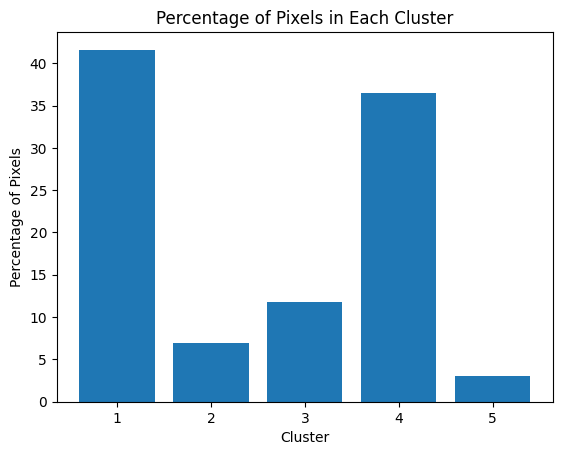

In [55]:
# Calculate percentage of pixels in each cluster
cluster_counts = np.bincount(labels_hsv)
total_pixels = height * width
percentages = (cluster_counts / total_pixels) * 100

# Display percentage of pixels in each cluster
for i, percentage in enumerate(percentages):
    print(f'Cluster {i + 1}: {percentage:.2f}% of pixels')

# Visualization of pixel distribution among clusters
plt.bar(range(1, num_clusters + 1), percentages)
plt.xlabel('Cluster')
plt.ylabel('Percentage of Pixels')
plt.title('Percentage of Pixels in Each Cluster')
plt.show()

In [ ]:
anomaly_threshold = 2.0

In [ ]:
anomalies = distances_scaled > anomaly_threshold

In [ ]:
anomaly_mask = anomalies.reshape((height, width))
anomaly_highlight = image.copy()
anomaly_highlight[anomaly_mask == 1] = [0, 0, 255]

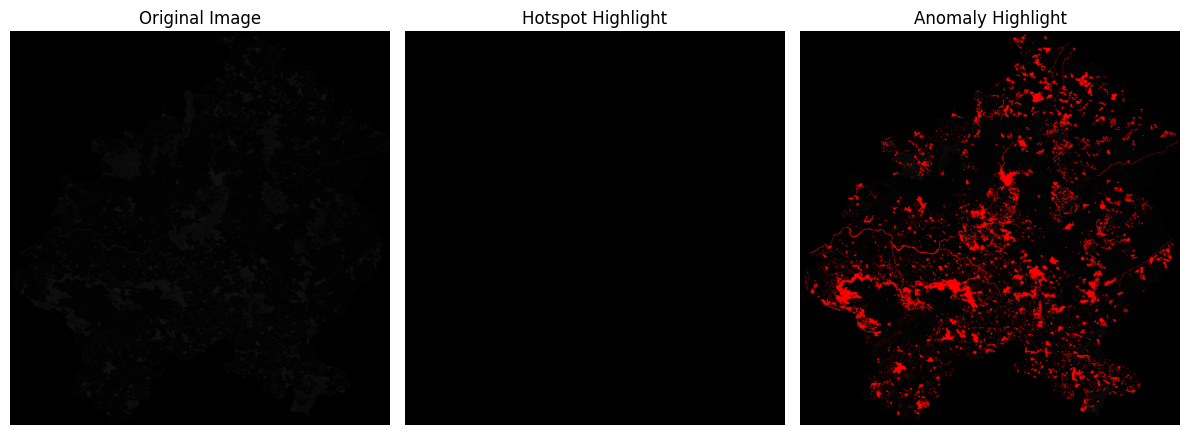

In [ ]:
# Display images using matplotlib (for Jupyter Notebook or online platforms)
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(hotspot_highlight, cv2.COLOR_BGR2RGB))
plt.title('Hotspot Highlight')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(anomaly_highlight, cv2.COLOR_BGR2RGB))
plt.title('Anomaly Highlight')
plt.axis('off')

plt.tight_layout()
plt.show()


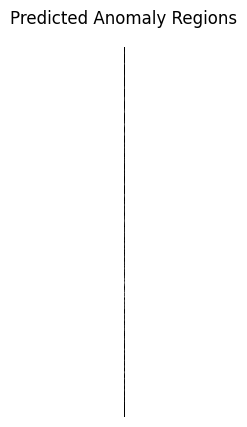

In [82]:
# Assuming 'anomalies' is the mask of identified anomalies from previous code

# Convert anomaly mask to binary (0: non-anomaly, 1: anomaly)
binary_anomalies = anomalies.astype(np.uint8)

# Apply erosion or dilation to the anomalies mask to predict potential future anomaly regions
kernel = np.ones((5, 5), np.uint8)  # Define the structuring element
# Use morphology to predict future anomaly regions
predicted_anomalies = cv2.morphologyEx(binary_anomalies, cv2.MORPH_CLOSE, kernel)

# Display the predicted anomaly regions
plt.imshow(predicted_anomalies, cmap='gray')
plt.title('Predicted Anomaly Regions')
plt.axis('off')
plt.show()

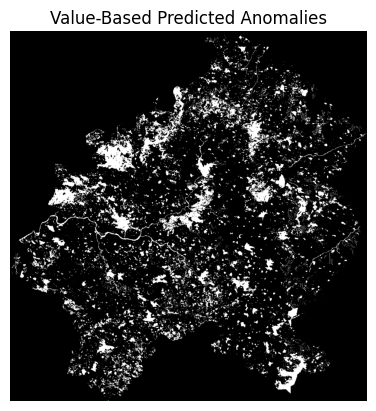

In [83]:
from sklearn.ensemble import IsolationForest

# Assuming 'image_2d' is the flattened 2D array of RGB values

# Train Isolation Forest model
isolation_forest = IsolationForest(random_state=42, contamination=0.1)  # Adjust contamination if needed
isolation_forest.fit(image_2d)

# Predict anomalies based on the trained model
anomaly_scores = isolation_forest.decision_function(image_2d)
threshold = np.percentile(anomaly_scores, 100 * 0.1)  # 0.1 represents contamination
predicted_anomalies = (anomaly_scores < threshold).astype(int)

# Reshape predicted anomalies to image shape for visualization
predicted_anomalies_image = predicted_anomalies.reshape((height, width))

# Display the predicted anomalies
plt.imshow(predicted_anomalies_image, cmap='gray')
plt.title('Value-Based Predicted Anomalies')
plt.axis('off')
plt.show()


In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
def detect_flood(image):
    # Implement a flood detection algorithm (e.g., color thresholding, segmentation)
    # Example: Simple color thresholding for blue regions (adjust these values)
    lower_blue = np.array([100, 0, 0])
    upper_blue = np.array([255, 100, 100])
    mask = cv2.inRange(image, lower_blue, upper_blue)

    # Example: Applying a colored mask to the original image
    flood_highlight = cv2.bitwise_and(image, image, mask=mask)

    return flood_highlight


In [ ]:
# Upload the satellite image file
uploaded = files.upload()


Saving 0910_vik.tif to 0910_vik.tif


In [ ]:
# Access the uploaded image
image_path = list(uploaded.keys())[0]
image = cv2.imread(image_path)


In [ ]:
# Detect flooded areas in the image
flooded_areas = detect_flood(image)


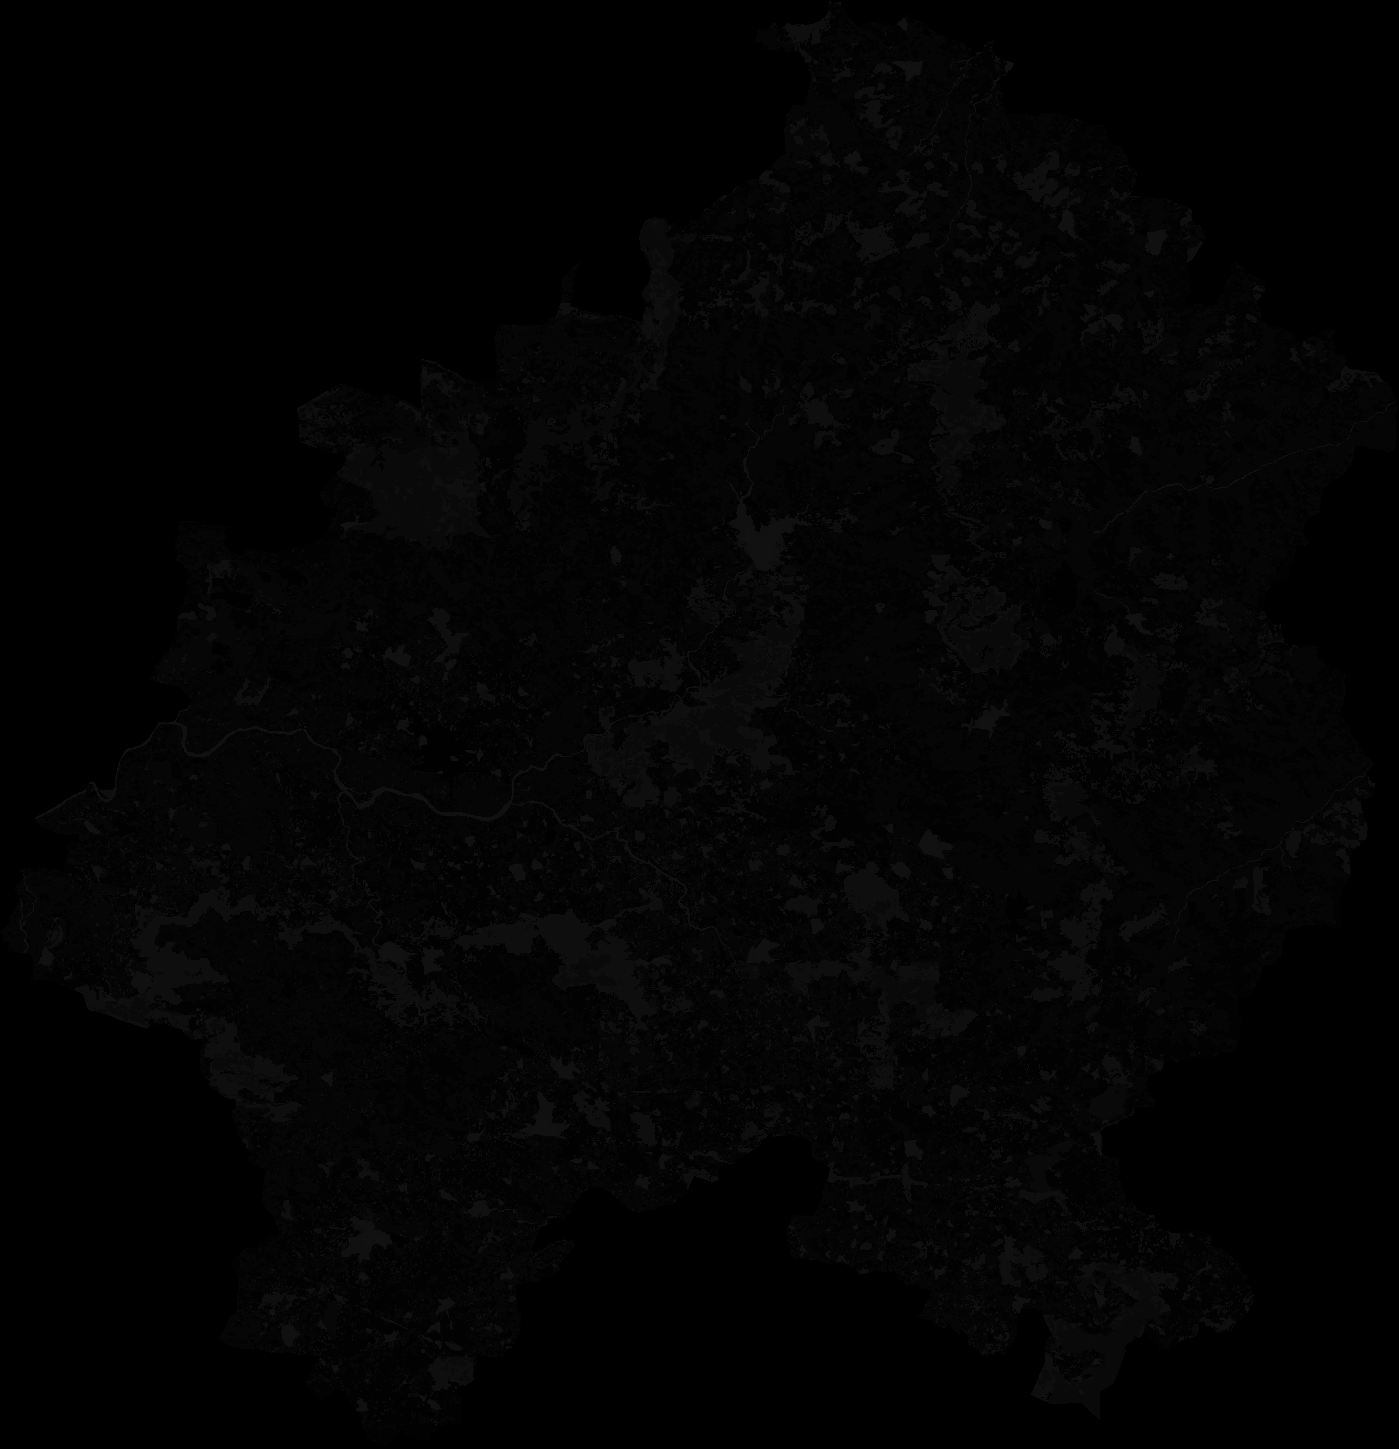

In [ ]:
# Display the original image
cv2_imshow(image)


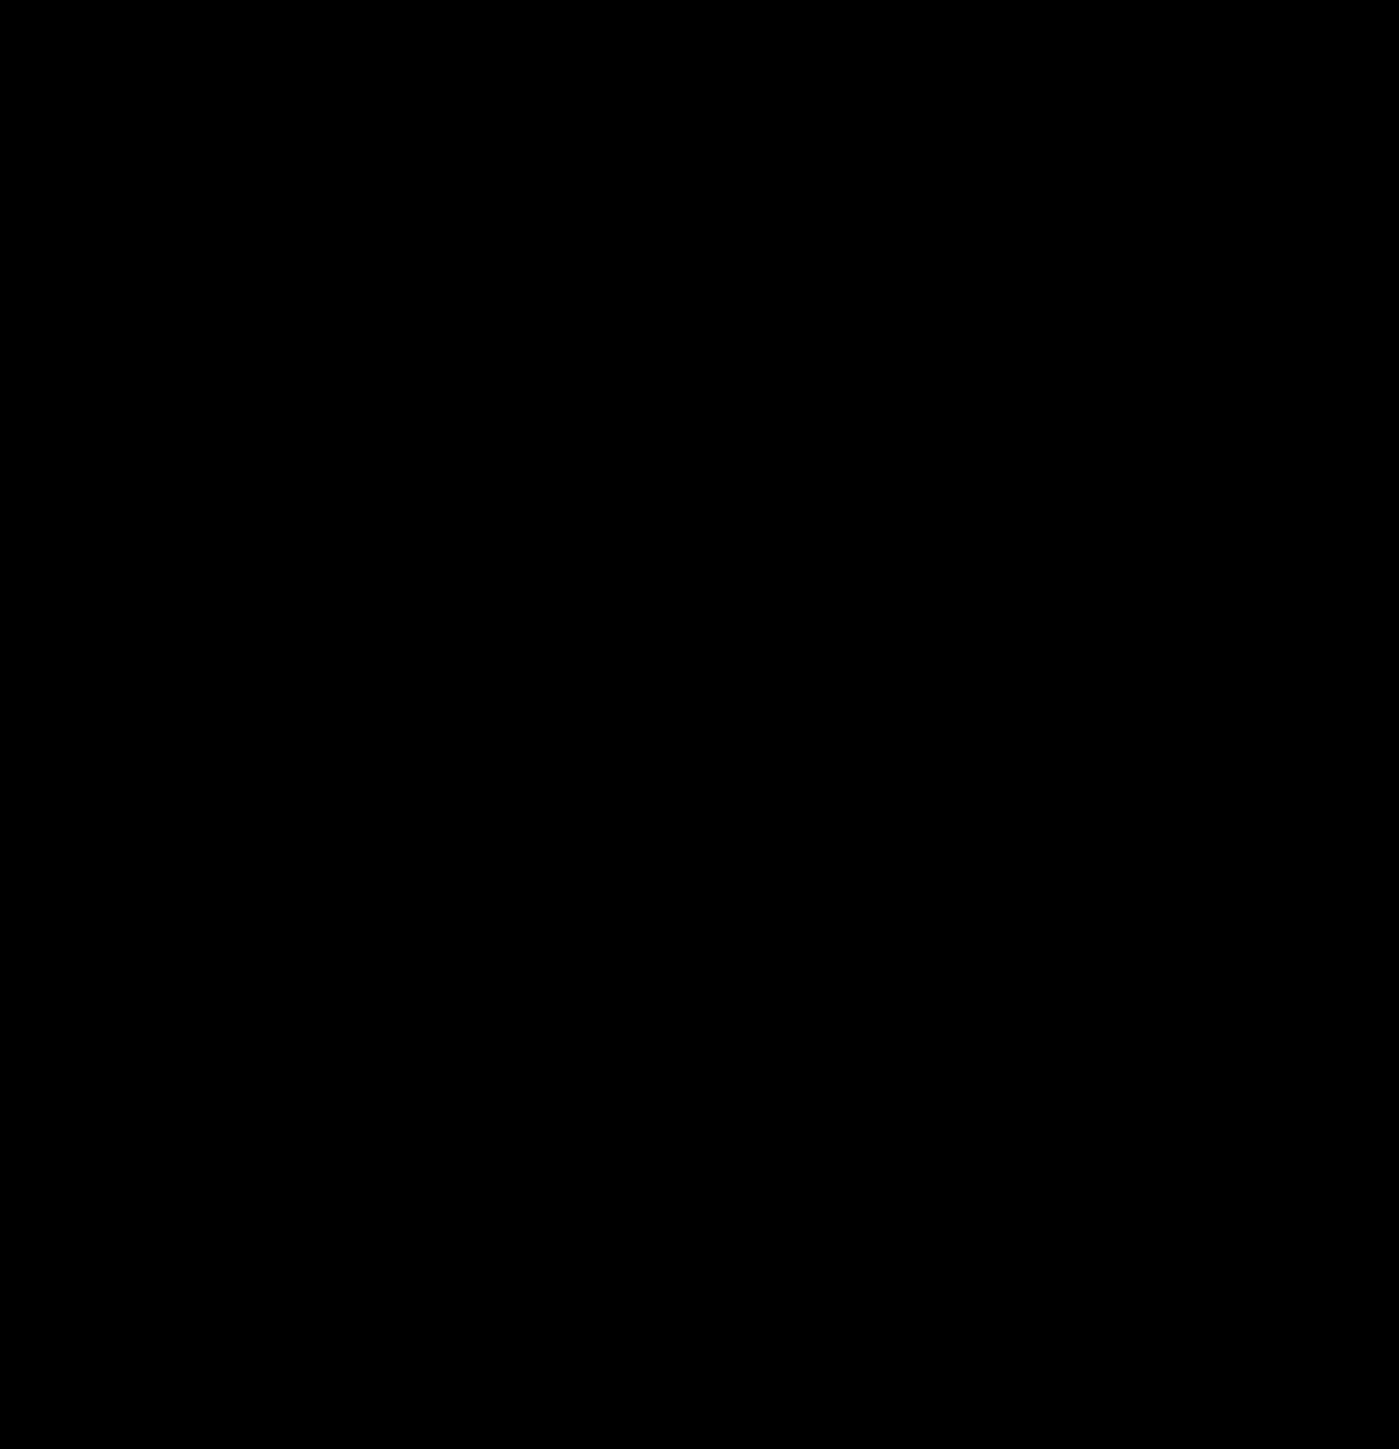

In [ ]:
# Display the detected flooded areas with changed color
cv2_imshow(flooded_areas)

In [86]:
# Assuming 'flooded_areas' is the result of detect_flood function

# Convert the detected flooded areas to a binary mask
binary_flooded_areas = cv2.cvtColor(flooded_areas, cv2.COLOR_BGR2GRAY)
ret, binary_flooded_areas = cv2.threshold(binary_flooded_areas, 1, 255, cv2.THRESH_BINARY)

# Calculate the percentage of the image covered by flooded areas
total_pixels = image.shape[0] * image.shape[1]
flooded_pixels = np.sum(binary_flooded_areas == 255)
percentage_flooded = (flooded_pixels / total_pixels) * 100

# Display the percentage of the image covered by flooded areas
print(f"Percentage of Flooded Areas: {percentage_flooded:.2f}%")

Percentage of Flooded Areas: 0.00%
